# Classification de PSSM selon leur localisation cellulaire

Gloria Benoit - M2BI

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
from keras.utils import to_categorical
import keras
import seaborn as sns
import sklearn.metrics
from sklearn.model_selection import train_test_split

## Récupération des données

### Chargement des données

In [3]:
import os
import requests
from tqdm import tqdm
import zipfile
from pandas import read_csv

def download_data():
    url="https://github.com/JJAlmagro/subcellular_localization/raw/refs/heads/master/notebook%20tutorial/data/reduced_train.npz"
    datasetFolderPath = "dataset/"
    file = "reduced_train.npz"
    FilePath = os.path.join(datasetFolderPath, file)

    if not os.path.exists(datasetFolderPath):
        os.makedirs(datasetFolderPath)

    def download_file(url, filename):
        response = requests.get(url, stream=True)
        with tqdm.wrapattr(open(filename, "wb"), "write", miniters=1,
                           total=int(response.headers.get('content-length', 0)),
                           desc=filename) as fout:
            for chunk in response.iter_content(chunk_size=4096):
                fout.write(chunk)

    # Download the zip file if it does not exist
    if not os.path.exists(FilePath):
        download_file(url, FilePath)

download_data()

dataset/reduced_train.npz: 100%|██████████| 8.52M/8.52M [00:00<00:00, 29.8MB/s]


In [4]:
# Data treatment
file_data_train = "dataset/reduced_train.npz"

train = np.load(file_data_train)
X_train = train["X_train"]
Y = train["y_train"]

print("Shape of dataset X")
print(X_train.shape)
print("Shape of dataset Y")
print(Y.shape)

Shape of dataset X
(2423, 400, 20)
Shape of dataset Y
(2423,)


In [5]:
classes = preprocessing.LabelEncoder()
classes.fit(Y)
classes_Y = classes.transform(Y)

onehot_Y = to_categorical(classes_Y)

### Visualisation des données

On a des PSSM pour des séquences de taille maximale 400 acides aminés (avec ajout de 0 si inférieure).

In [6]:
print(X_train[0])

[[0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [7]:
print(np.sum(X_train[0], axis=1))

[1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         0.9999999  0.99999994 0.9999999  0.9999999  0.98999995
 0.99999994 1.0000001  0.99999994 0.99999994 1.01       1.
 1.         0.9999999  0.99999994 0.99999994 1.02       1.01
 1.0099999  0.9899999  0.99999994 0.98999995 1.         1.01
 0.99999994 0.99       0.99       0.99       0.99       0.98999995
 1.         0.99       1.         1.01       1.         1.01
 1.0100001  1.         1.         0.99       1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 0.99999994 1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         0.99       1.01
 1.         1.01       1.         1.0100001  0.9999999  0.99999994
 1.         0.99999994 1

Pour chaque position, on a bien un total des probabilités de présence égale à 1. Les valeurs très proches de 1 sont causées par l'approximation des valeurs à moins de décimales.

Pour cette première donnée, on observe une somme à 0 à partir de la 161e position. Cela signifie que la séquence utilisée faisait 160 acides aminés de longueur, et pas 400.

### Formattage des données

On ne possède pas d'échantillon de test, alors on va le construire à partir de l'échantillon de train.

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X_train, onehot_Y, test_size=0.2, random_state=3, shuffle=True)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(1938, 400, 20)
(1938, 10)
(485, 400, 20)
(485, 10)


In [9]:
print(set(np.argmax(y_train, axis=1)))
print(set(np.argmax(y_test, axis=1)))

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}


In [10]:
# Mélange des données
ns =  X_train.shape[0]
np.random.seed()
shuffle_index = np.random.permutation(ns)
X_train, y_train = X_train[shuffle_index,:], y_train[shuffle_index,]

### Répartion des classes

On a 10 classes, correspondant à 10 localisations subcellulaires:

*   Noyau
*   Cytoplasme
*   Extracellulaire
*   Mitochondrie
*   Membrane plasmique
*   Réticulum endoplasmique
*   Plaste
*   Appareil de Golgi
*   Lysosome
*   Vacuole

In [11]:
class_labels = ["Nucleus", "Cytoplasm", "Extracellular", "Mitochondrion", "Cell membrane", "Endoplasmic reticulum", "Plastid", "Golgi", "Lysosome", "Vacuole"]

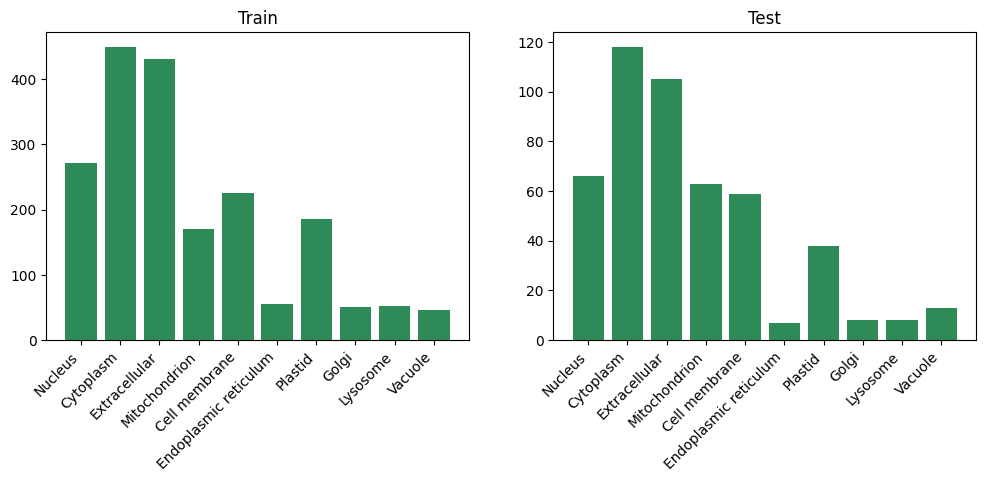

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

data = list(np.argmax(y_train, axis=1))
counts = np.bincount(data)

ax[0].bar(range(10), counts, width=0.8, align='center', color='seagreen')
ax[0].set_xticks(range(10), class_labels, rotation=45, ha='right')
ax[0].set_title("Train")

data = list(np.argmax(y_test, axis=1))
counts = np.bincount(data)

ax[1].bar(range(10), counts, width=0.8, align='center', color='seagreen')
ax[1].set_xticks(range(10), class_labels, rotation=45, ha='right')
ax[1].set_title("Test")

plt.show()

Pour l'échantillon train, on observe une grande disparité dans la distribution des classes. Les classes les plus petites (RE, Golgi, Lysosome, Vacuole) représentent à peine 1/10 de la taille de la plus grande classe (Cytoplasme). Cela va donc entrainer un biais dans l'apprentissage des données, et affecter les performances.

Pour pallier cela, on introduit des poids sur les classes selon leur distribution.

L'échantillon test a plus ou moins la même distribution des classes, avec comme seule différence la proportion de la 3e classe (Mitochondrie) qui est plus élevée que dans le train.

In [13]:
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(np.argmax(y_train, axis=1)),
    y=np.argmax(y_train, axis=1)
)
class_weights_dict = dict(enumerate(class_weights))

## Premier apprentissage : réseau avec convolution (CNN)

In [ ]:
from keras.models import Sequential
from keras.layers import Conv1D, Flatten, Dense
from keras import optimizers

### Construction du modèle

In [ ]:
def construct_cnn():
    model = Sequential()

    model.add(Conv1D(filters=32, kernel_size=3, activation='relu', kernel_initializer='he_uniform', input_shape=(400, 20)))

    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', kernel_initializer='he_uniform'))

    model.add(Flatten())

    model.add(Dense(10, activation='softmax'))

    opt = optimizers.Adam(learning_rate=0.001)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'], weighted_metrics=["accuracy"])

    return model

In [ ]:
model_cnn = construct_cnn()
model_cnn.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_114 (Conv1D)                  │ (None, 398, 32)             │           1,952 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_115 (Conv1D)                  │ (None, 396, 64)             │           6,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_7 (Flatten)                  │ (None, 25344)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 10)                  │         253,450 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 261,610 (1021.91 KB)

 Trainable params: 261,610 (1021.91 KB)

 Non-trainable params: 0 (0.00 B)

### Performances sans pondération des poids

In [ ]:
history_cnn = model_cnn.fit(X_train, y_train, validation_split=0.1, epochs=10, batch_size=50)

Epoch 1/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - accuracy: 0.2823 - loss: 1.9815 - weighted_accuracy: 0.2823 - val_accuracy: 0.5206 - val_loss: 1.6012 - val_weighted_accuracy: 0.5206
Epoch 2/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.7191 - loss: 1.1028 - weighted_accuracy: 0.7191 - val_accuracy: 0.7062 - val_loss: 1.0301 - val_weighted_accuracy: 0.7062
Epoch 3/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - accuracy: 0.9001 - loss: 0.4303 - weighted_accuracy: 0.9001 - val_accuracy: 0.7423 - val_loss: 0.8513 - val_weighted_accuracy: 0.7423
Epoch 4/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - accuracy: 0.9626 - loss: 0.1819 - weighted_accuracy: 0.9626 - val_accuracy: 0.7526 - val_loss: 0.8031 - val_weighted_accuracy: 0.7526
Epoch 5/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.9832 - loss: 0.0946 - weighted_accuracy: 0.9832 - val_accuracy: 0.7268 - val_loss: 0.8020 - val_weighted_accuracy: 0.7268
Epoch 6/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.

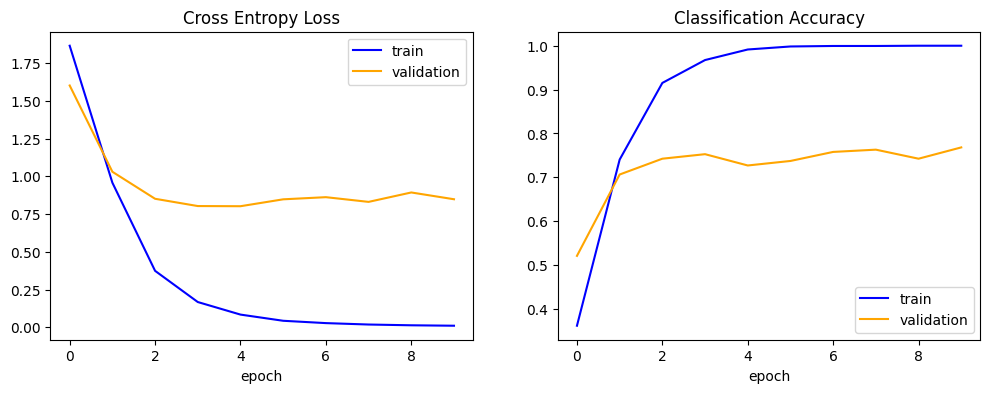

In [ ]:
plt.figure(figsize=(12, 4))
# plot loss
plt.subplot(121)
plt.title('Cross Entropy Loss')
plt.plot(history_cnn.history['loss'], color='blue', label='train')
plt.plot(history_cnn.history['val_loss'], color='orange', label='validation')
plt.xlabel('epoch')

plt.legend()

# plot accuracy
plt.subplot(122)
plt.title('Classification Accuracy')
plt.plot(history_cnn.history['accuracy'], color='blue', label='train')
plt.plot(history_cnn.history['val_accuracy'], color='orange', label='validation')
plt.xlabel('epoch')

plt.legend()
plt.show()

Les performances ne sont pas bonnes. On observe que les courbes de validation et de train sont très éloignées.

Pour la loss et pour l'accuracy, on a une courbe de validation qui n'est pas à la hauteur de celle de train, mais elle ne semble pas trop augmenter ou diminuer. On a pas encore de l'overfitting, mais les performances stagnent.

In [ ]:
scores = model_cnn.evaluate(X_test, y_test)
print("Neural network accuracy: %.2f%%" % (scores[1]*100))

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7426 - loss: 0.8174 - weighted_accuracy: 0.7426
Neural network accuracy: 74.85%


Une accuracy de 74,85% n'est pas mauvaise en soit, mais comparé au train on a une vraie différence.

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


<Axes: >

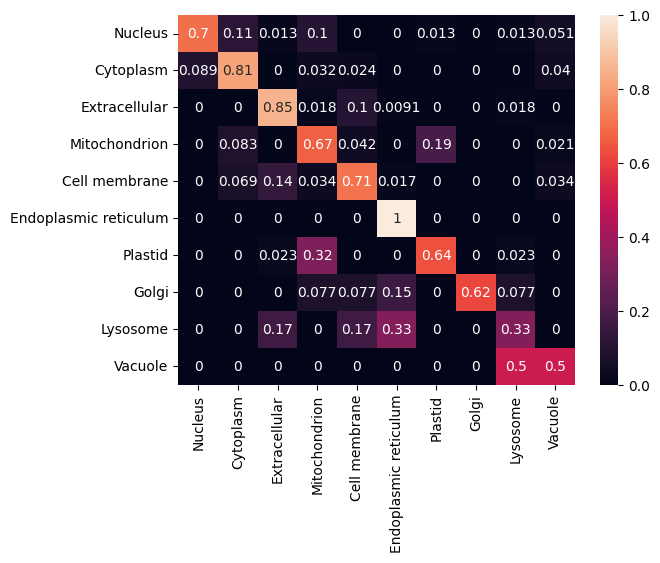

In [ ]:
prediction = model_cnn.predict(X_test)

test_pred = np.argmax(prediction,axis = 1)
test_true = np.argmax(y_test,axis = 1)

sns.heatmap(sklearn.metrics.confusion_matrix(test_pred, test_true, normalize="true"), annot=True, xticklabels=class_labels, yticklabels=class_labels)

Les meilleures classes sont principalement celles qui sont beaucoup représentées, comme la classe 1 (Cytoplasme) ou 2 (Extracellulaire), et les moins représentées ont de pires performances, comme la classe 8 (Lysosome) ou 9 (Vacuole). Cependant, on observe des exceptions comme la classe 5 (RE), qui a le meilleur taux de bien prédit bien qu'elle ne soit que peu représentée dans les échantillons.

### Performances avec pondération des poids

On espère améliorer ces résultats en utilisant les poids de chaque classe.

In [ ]:
model_cnn = construct_cnn()
history_cnn = model_cnn.fit(X_train, y_train, validation_split=0.1, epochs=10, batch_size=50, class_weight=class_weights_dict)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 95ms/step - accuracy: 0.1767 - loss: 2.2655 - weighted_accuracy: 0.1861 - val_accuracy: 0.4330 - val_loss: 1.8912 - val_weighted_accuracy: 0.4330
Epoch 2/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - accuracy: 0.5958 - loss: 1.3052 - weighted_accuracy: 0.6616 - val_accuracy: 0.6495 - val_loss: 1.1538 - val_weighted_accuracy: 0.6495
Epoch 3/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.8844 - loss: 0.4596 - weighted_accuracy: 0.9055 - val_accuracy: 0.6598 - val_loss: 0.9808 - val_weighted_accuracy: 0.6598
Epoch 4/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 4s 68ms/step - accuracy: 0.9499 - loss: 0.2006 - weighted_accuracy: 0.9670 - val_accuracy: 0.7113 - val_loss: 0.7874 - val_weighted_accuracy: 0.7113
Epoch 5/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.9871 - loss: 0.0900 - weighted_accuracy: 0.9922 - val_accuracy: 0.7526 - val_loss: 0.7809 - val_weighted_accuracy: 0.7526
Epoch 6/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.

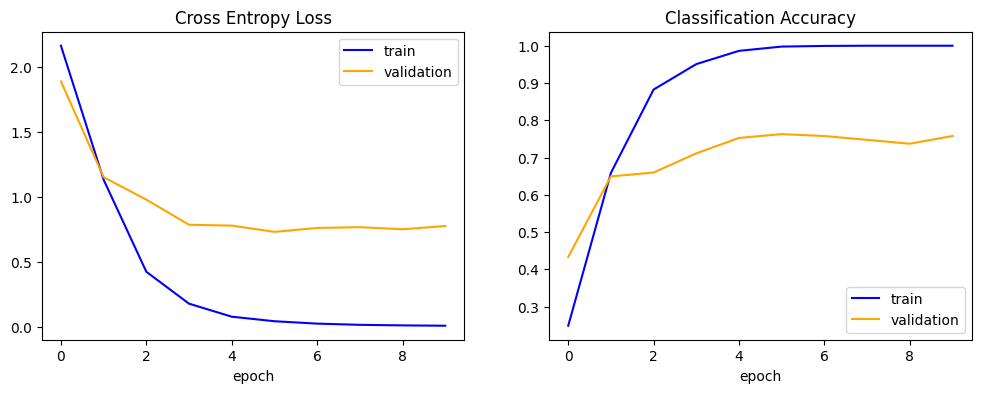

In [ ]:
plt.figure(figsize=(12, 4))
# plot loss
plt.subplot(121)
plt.title('Cross Entropy Loss')
plt.plot(history_cnn.history['loss'], color='blue', label='train')
plt.plot(history_cnn.history['val_loss'], color='orange', label='validation')
plt.xlabel('epoch')

plt.legend()

# plot accuracy
plt.subplot(122)
plt.title('Classification Accuracy')
plt.plot(history_cnn.history['accuracy'], color='blue', label='train')
plt.plot(history_cnn.history['val_accuracy'], color='orange', label='validation')
plt.xlabel('epoch')

plt.legend()
plt.show()

Les courbes ont a priori la même allure, on ne dépasse pas une accuracy de 80%.

In [ ]:
scores = model_cnn.evaluate(X_test, y_test)
print("Neural network accuracy: %.2f%%" % (scores[1]*100))

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7778 - loss: 0.7963 - weighted_accuracy: 0.7778
Neural network accuracy: 77.73%


On a néanmoins une amélioration de l'accuracy générale du réseau, avec une augmentation de 3 points de pourcentage.

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


<Axes: >

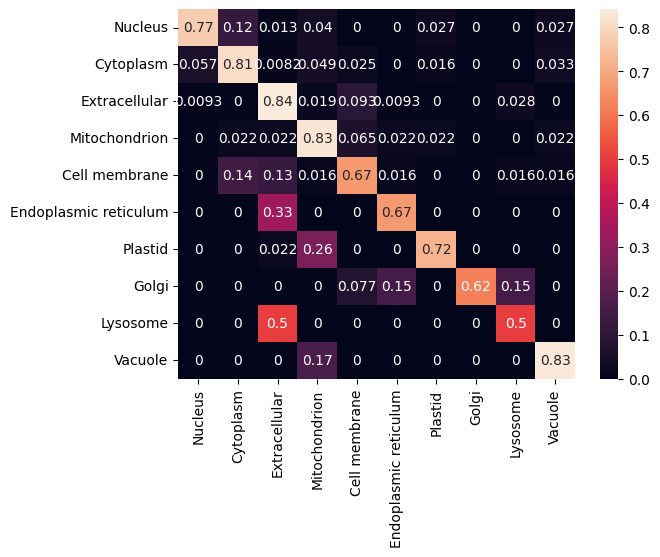

In [ ]:
prediction = model_cnn.predict(X_test)

test_pred = np.argmax(prediction,axis = 1)
test_true = np.argmax(y_test,axis = 1)

sns.heatmap(sklearn.metrics.confusion_matrix(test_pred, test_true, normalize="true"), annot=True, xticklabels=class_labels, yticklabels=class_labels)

De même, les prédictions par classe ne sont pas optimales mais sont plus homogènes. Les performances semblent moins correlées à la représentation de chaque classe dans les échantillons.

## Optimisation des paramètres

Pour améliorer nos performances, on va chercher les paramètres optimaux par la méthode de GridSearch.

In [ ]:
!pip install scikeras

In [ ]:
import numpy as np
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Flatten, Dense

In [ ]:
def cnn_grid(learning_rate=0.001):
    model = Sequential()

    model.add(Conv1D(filters=64, kernel_size=3, activation='relu',
                     kernel_initializer='he_uniform', input_shape=(400, 20)))

    model.add(Conv1D(filters=32, kernel_size=3, activation='relu', kernel_initializer='he_uniform'))

    model.add(Flatten())

    model.add(Dense(10, activation='softmax'))

    opt = optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'], weighted_metrics=["accuracy"])

    return model

In [ ]:
model = KerasClassifier(build_fn=cnn_grid, epochs=10, learning_rate=0.005)

param_grid = {
    'learning_rate': [0.0001, 0.0005, 0.001, 0.0025, 0.005],
    'batch_size': [16, 32, 64, 128],
}

grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3, verbose=1)
grid_result = grid.fit(X_train, y_train, epochs=10, class_weight=class_weights_dict)

print(f"Meilleurs paramètres : {grid_result.best_params_}")
print(f"Meilleure accuracy : {grid_result.best_score_}")

Fitting 3 folds for each of 20 candidates, totalling 60 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.2336 - loss: 2.2674 - weighted_accuracy: 0.2146
Epoch 2/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.7385 - loss: 0.8246 - weighted_accuracy: 0.7574
Epoch 3/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.9230 - loss: 0.2721 - weighted_accuracy: 0.9415
Epoch 4/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.9757 - loss: 0.0947 - weighted_accuracy: 0.9856
Epoch 5/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - accuracy: 0.9945 - loss: 0.0419 - weighted_accuracy: 0.9962
Epoch 6/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.9998 - loss: 0.0184 - weighted_accuracy: 0.9999
Epoch 7/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.9990 - loss: 0.0138 - weighted_accuracy: 0.9992
Epoch 8/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.9921 - loss: 0.0363 - weighted_accuracy: 0.9961
Epoch 9/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.9998 - loss: 

GridSearch results:
[[0.63983488 0.74251806 0.75335397 0.74458204 0.65325077]
 [0.5748194  0.74458204 0.74097007 0.74200206 0.70485036]
 [0.46026832 0.70227038 0.72961816 0.74355005 0.70691434]
 [0.3003096  0.6630547  0.72187822 0.73839009 0.72807018]]


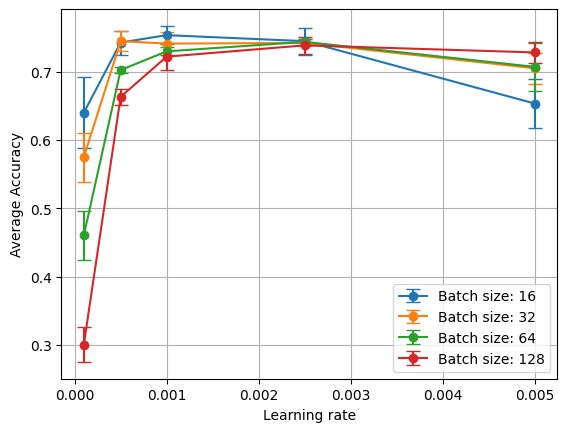

In [ ]:
def plot_grid_search(cv_results, grid_param_1, grid_param_2, name_param_1, name_param_2):
    scores_mean = cv_results['mean_test_score']
    scores_mean = np.array(scores_mean).reshape(len(grid_param_2), len(grid_param_1))

    print(f"GridSearch results:\n{scores_mean}")

    scores_sd = cv_results['std_test_score']
    scores_sd = np.array(scores_sd).reshape(len(grid_param_2), len(grid_param_1))


    for idx, val in enumerate(grid_param_2):
        plt.errorbar(grid_param_1, scores_mean[idx, :], yerr=scores_sd[idx, :], fmt='-o',
                    label=name_param_2 + ': ' + str(val), capsize=5)

    plt.xlabel(name_param_1)
    plt.ylabel('Average Accuracy')
    plt.legend(loc="best")
    plt.grid('on')
    plt.show()

plot_grid_search(grid_result.cv_results_, param_grid['learning_rate'], param_grid['batch_size'], 'Learning rate', 'Batch size')

On détermine donc que la taille de batch optimale est 16, et que le taux d'apprentissage optimal est 0,001.

Epoch 1/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - accuracy: 0.1390 - loss: 2.4313 - weighted_accuracy: 0.1549 - val_accuracy: 0.5604 - val_loss: 1.3976 - val_weighted_accuracy: 0.5604
Epoch 2/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.7211 - loss: 1.0530 - weighted_accuracy: 0.7257 - val_accuracy: 0.6192 - val_loss: 1.1021 - val_weighted_accuracy: 0.6192
Epoch 3/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.9293 - loss: 0.2853 - weighted_accuracy: 0.9490 - val_accuracy: 0.6594 - val_loss: 1.0394 - val_weighted_accuracy: 0.6594
Epoch 4/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.9792 - loss: 0.1156 - weighted_accuracy: 0.9893 - val_accuracy: 0.7539 - val_loss: 0.8000 - val_weighted_accuracy: 0.7539
Epoch 5/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.9950 - loss: 0.0410 - weighted_accuracy: 0.9964 - val_accuracy: 0.7384 - val_loss: 0.8873 - val_weighted_accuracy: 0.7384
Epoch 6/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - accuracy: 0.

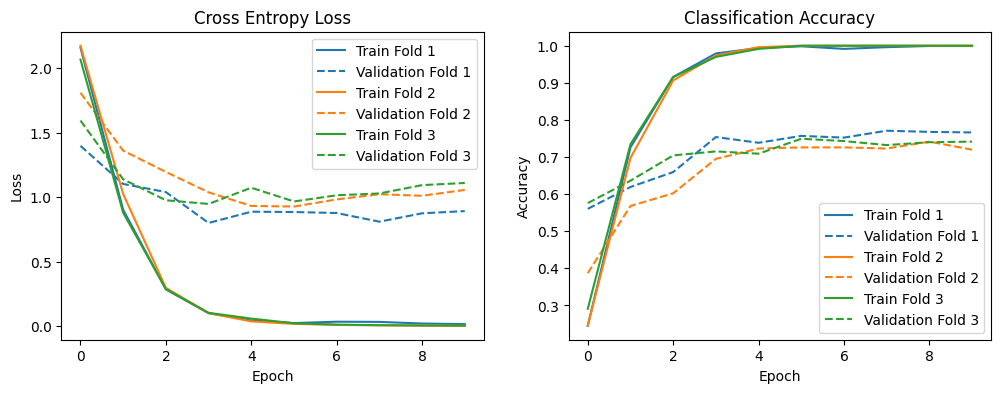

In [ ]:
from sklearn.model_selection import KFold

best_model = None
best_accuracy = 0

kfold = KFold(n_splits=3)

accuracies = []

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

for fold, (train_index, val_index) in enumerate(kfold.split(X_train), 1):
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

    model = cnn_grid(learning_rate=best_learning_rate)

    history = model.fit(X_train_fold, y_train_fold, validation_data=(X_val_fold, y_val_fold),
                        epochs=10, batch_size=best_batch_size, class_weight=class_weights_dict)

    scores = model.evaluate(X_val_fold, y_val_fold)
    accuracies.append(scores[1] * 100)

    # Sauvegarder le meilleur modèle
    if scores[1] > best_accuracy:
        best_accuracy = scores[1]
        best_model = model

    color = next(plt.gca()._get_lines.prop_cycler)['color']

    # Loss
    axes[0].plot(history.history['loss'], label=f'Train Fold {fold}', color=color)
    axes[0].plot(history.history['val_loss'], label=f'Validation Fold {fold}', linestyle='--', color=color)

    # Accuracy
    axes[1].plot(history.history['accuracy'], label=f'Train Fold {fold}', color=color)
    axes[1].plot(history.history['val_accuracy'], label=f'Validation Fold {fold}', linestyle='--', color=color)

axes[0].set_title('Cross Entropy Loss')
axes[1].set_title('Classification Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[0].legend(loc='upper right')
axes[1].legend(loc='lower right')

plt.show()

La cross-validation illustre la non robustesse de notre modèle. Les courbes des différents folds ont la même tendance mais varient.

In [ ]:
print(f"Cross-validation accuracy: {np.mean(accuracies):.2f}% (±{np.std(accuracies):.2f}%)")
print(f"Best model accuracy: {best_accuracy * 100:.2f}%")

Cross-validation accuracy: 74.25% (±1.90%)
Best model accuracy: 76.63%


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7698 - loss: 0.8243 - weighted_accuracy: 0.7698
Neural network accuracy: 75.26%
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


<Axes: >

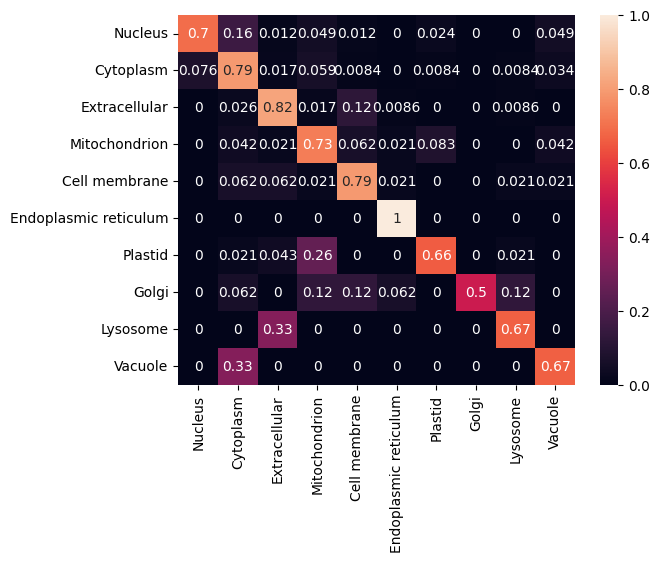

In [ ]:
scores = best_model.evaluate(X_test, y_test)
print("Neural network accuracy: %.2f%%" % (scores[1]*100)),

prediction = best_model.predict(X_test)

test_pred = np.argmax(prediction,axis = 1)
test_true = np.argmax(y_test,axis = 1)

sns.heatmap(sklearn.metrics.confusion_matrix(test_pred, test_true, normalize="true"), annot=True, xticklabels=class_labels, yticklabels=class_labels)

L'hypothèse de non robustesse est renforcée puisque notre modèle aux paramètres "optimaux" obtient une pire accuracy générale que nos modèles précédents (réduction de 2 points de pourcentage).

## Second apprentissage : réseau neuronal résiduel (ResNet)

In [ ]:
from keras import Input, Model
from keras.layers import Conv1D, Flatten, Dense
from keras.layers import AveragePooling1D, Activation, BatchNormalization, Add

def residual_module(input, channels):
  stride=1
  kernel_size=3
  x_shortcut = input
  x = BatchNormalization()(input)
  x = Activation('relu')(x)
  x = Conv1D(channels, (1))(x)

  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = Conv1D(channels, kernel_size, padding='same', strides=stride)(x)
  output = Add()([x, x_shortcut])
  return(output)

def construct_resnet():
    n_residual = 1
    print("Simple residual network with {} modules".format(n_residual))

    inputs = Input(shape=(400, 20))

    residual_i = inputs
    for _ in range(n_residual):
        residual_i = residual_module(residual_i, 20)

    gavg_1 = AveragePooling1D((2), strides=(1))(residual_i)

    flat_1 = Flatten()(gavg_1)

    output = Dense(10, activation="softmax")(flat_1)

    model = Model(inputs=inputs, outputs=output)

    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=['accuracy'], weighted_metrics=["accuracy"])

    return model

In [ ]:
model_resnet = construct_resnet()
model_resnet.summary()

Simple residual network with 1 modules


Model: "functional_100"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_28            │ (None, 400, 20)        │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_8     │ (None, 400, 20)        │             80 │ input_layer_28[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_8 (Activation) │ (None, 400, 20)        │              0 │ batch_normalization_8… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_56 (Conv1D)        │ (None, 400, 20)        │            420 │ activation_8[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_9     │ (None, 400, 20)        │             80 │ conv1d_56[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_9 (Activation) │ (None, 400, 20)        │              0 │ batch_normalization_9… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_57 (Conv1D)        │ (None, 400, 20)        │          1,220 │ activation_9[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_4 (Add)               │ (None, 400, 20)        │              0 │ conv1d_57[0][0],       │
│                           │                        │                │ input_layer_28[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ average_pooling1d_4       │ (None, 399, 20)        │              0 │ add_4[0][0]            │
│ (AveragePooling1D)        │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_28 (Flatten)      │ (None, 7980)           │              0 │ average_pooling1d_4[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_28 (Dense)          │ (None, 10)             │         79,810 │ flatten_28[0][0]       │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 81,610 (318.79 KB)

 Trainable params: 81,530 (318.48 KB)

 Non-trainable params: 80 (320.00 B)

In [ ]:
history_resnet = model_resnet.fit(X_train, y_train, validation_split=0.2, epochs=10, batch_size=50, class_weight=class_weights_dict)

Epoch 1/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - accuracy: 0.2299 - loss: 2.3712 - weighted_accuracy: 0.2300 - val_accuracy: 0.2680 - val_loss: 2.0664 - val_weighted_accuracy: 0.2680
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - accuracy: 0.8009 - loss: 0.6782 - weighted_accuracy: 0.8123 - val_accuracy: 0.1881 - val_loss: 2.0742 - val_weighted_accuracy: 0.1881
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.9287 - loss: 0.2701 - weighted_accuracy: 0.9496 - val_accuracy: 0.1675 - val_loss: 2.1687 - val_weighted_accuracy: 0.1675
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.9753 - loss: 0.1300 - weighted_accuracy: 0.9872 - val_accuracy: 0.1727 - val_loss: 2.2087 - val_weighted_accuracy: 0.1727
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.9957 - loss: 0.0685 - weighted_accuracy: 0.9979 - val_accuracy: 0.1907 - val_loss: 2.1057 - val_weighted_accuracy: 0.1907
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.

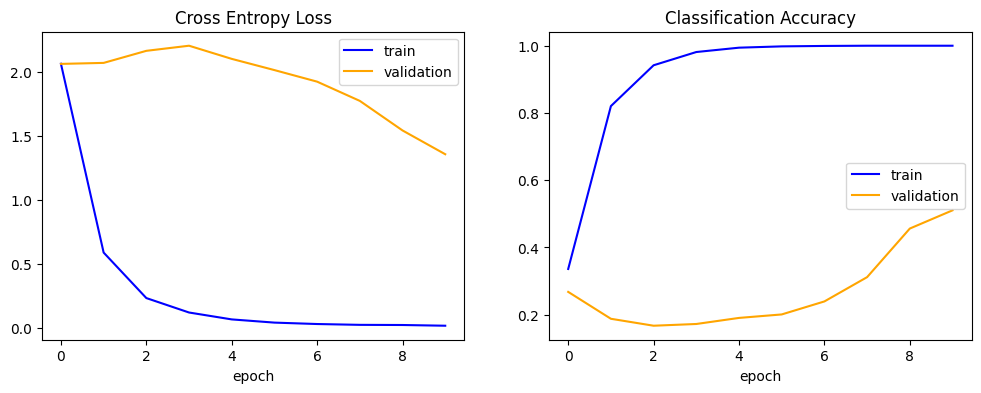

In [ ]:
plt.figure(figsize=(12, 4))

# plot loss
plt.subplot(121)
plt.title('Cross Entropy Loss')
plt.plot(history_resnet.history['loss'], color='blue', label='train')
plt.plot(history_resnet.history['val_loss'], color='orange', label='validation')
plt.xlabel('epoch')

plt.legend()

# plot accuracy
plt.subplot(122)
plt.title('Classification Accuracy')
plt.plot(history_resnet.history['accuracy'], color='blue', label='train')
plt.plot(history_resnet.history['val_accuracy'], color='orange', label='validation')
plt.xlabel('epoch')

plt.legend()
plt.show()

Simple residual network with 1 modules
Epoch 1/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - accuracy: 0.2151 - loss: 2.3087 - weighted_accuracy: 0.1959 - val_accuracy: 0.2647 - val_loss: 2.2103 - val_weighted_accuracy: 0.2647
Epoch 2/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.7725 - loss: 0.8183 - weighted_accuracy: 0.8349 - val_accuracy: 0.2693 - val_loss: 2.1784 - val_weighted_accuracy: 0.2693
Epoch 3/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.9166 - loss: 0.3035 - weighted_accuracy: 0.9477 - val_accuracy: 0.1920 - val_loss: 2.1290 - val_weighted_accuracy: 0.1920
Epoch 4/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.9773 - loss: 0.1356 - weighted_accuracy: 0.9881 - val_accuracy: 0.1842 - val_loss: 2.1281 - val_weighted_accuracy: 0.1842
Epoch 5/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.9972 - loss: 0.0781 - weighted_accuracy: 0.9986 - val_accuracy: 0.1997 - val_loss: 2.1306 - val_weighted_accuracy: 0.1997
Epoch 6/10
26/26 ━━━━━━━━━

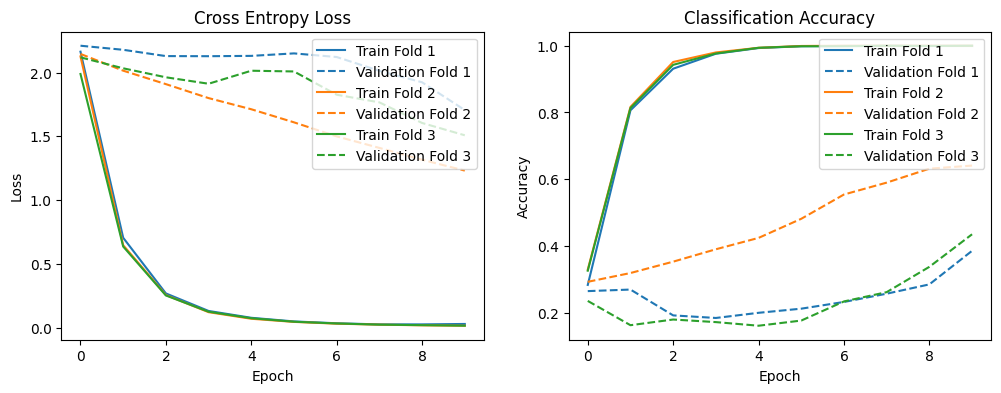

In [ ]:
from sklearn.model_selection import KFold

best_model = None
best_accuracy = 0

kfold = KFold(n_splits=3)

accuracies = []

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

for fold, (train_index, val_index) in enumerate(kfold.split(X_train), 1):
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

    model = construct_resnet()

    history = model.fit(X_train_fold, y_train_fold, validation_data=(X_val_fold, y_val_fold),
                        epochs=10, batch_size=50, class_weight=class_weights_dict)

    scores = model.evaluate(X_val_fold, y_val_fold)
    accuracies.append(scores[1] * 100)

    # Sauvegarder le meilleur modèle
    if scores[1] > best_accuracy:
        best_accuracy = scores[1]
        best_model = model

    color = next(plt.gca()._get_lines.prop_cycler)['color']

    # Loss
    axes[0].plot(history.history['loss'], label=f'Train Fold {fold}', color=color)
    axes[0].plot(history.history['val_loss'], label=f'Validation Fold {fold}', linestyle='--', color=color)

    # Accuracy
    axes[1].plot(history.history['accuracy'], label=f'Train Fold {fold}', color=color)
    axes[1].plot(history.history['val_accuracy'], label=f'Validation Fold {fold}', linestyle='--', color=color)

axes[0].set_title('Cross Entropy Loss')
axes[1].set_title('Classification Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[0].legend(loc='upper right')
axes[1].legend(loc='upper right')

plt.show()

La cross-validation met en évidence que le modèle n'est pas robuste. La loss est plus ou moins la même, mais l'accuracy varie beaucoup. On observe néanmoins que la tendance est la même pour les 3 folds, que ce soit pour la loss ou l'accuracy.

On explique cela par le manque de données, et l'hétérogénéité des échantillons.

In [ ]:
scores = best_model.evaluate(X_test, y_test)
print("Neural network accuracy: %.2f%%" % (scores[1]*100))

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6886 - loss: 1.1787 - weighted_accuracy: 0.6886
Neural network accuracy: 67.01%


Un modèle à 67,01% d'accuracy n'est pas si mauvais, mais cette valeur varie trop en raison de la non robustesse de notre modèle.

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


<Axes: >

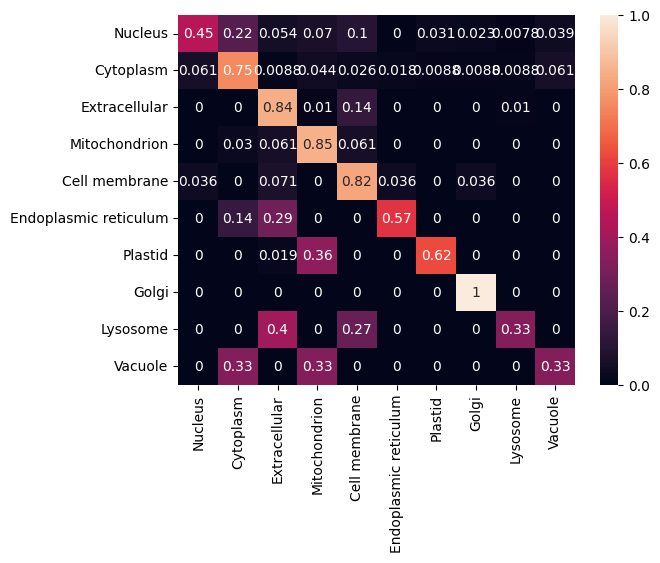

In [ ]:
prediction = best_model.predict(X_test)

test_pred = np.argmax(prediction,axis = 1)
test_true = np.argmax(y_test,axis = 1)

sns.heatmap(sklearn.metrics.confusion_matrix(test_pred, test_true, normalize="true"), annot=True, xticklabels=class_labels, yticklabels=class_labels)

Certaines classes sont très bien prédites et d'autres pas du tout. Néanmoins, on peut souligner qu'on est toujours meilleur que le hasard (10%). Le modèle est donc meilleur que le hasard, mais pas robuste.

### Augmentation du nombre de blocs

Les réseaux ResNet ne sont vraiment efficaces qu'à partir de 20 répétitions du bloc. On va donc tester d'augmenter le nombre de bloc pour observer la fluctuation de la prédiction.

#### 20 répétitions

In [16]:
def residual_module(input, channels):
  stride=1
  kernel_size=3
  x_shortcut = input
  x = BatchNormalization()(input)
  x = Activation('relu')(x)
  x = Conv1D(channels, (1))(x)

  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = Conv1D(channels, kernel_size, padding='same', strides=stride)(x)
  output = Add()([x, x_shortcut])
  return(output)

def construct_resnet():
    n_residual = 20
    print("Simple residual network with {} modules".format(n_residual))

    inputs = Input(shape=(400, 20))

    residual_i = inputs
    for _ in range(n_residual):
        residual_i = residual_module(residual_i, 20)

    gavg_1 = AveragePooling1D((2), strides=(1))(residual_i)

    flat_1 = Flatten()(gavg_1)

    output = Dense(10, activation="softmax")(flat_1)

    model = Model(inputs=inputs, outputs=output)

    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=['accuracy'], weighted_metrics=["accuracy"])

    return model

In [17]:
model_resnet = construct_resnet()
model_resnet.summary()

Simple residual network with 20 modules


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 400, 20)        │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 400, 20)        │             80 │ input_layer_1[0][0]    │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 400, 20)        │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d (Conv1D)           │ (None, 400, 20)        │            420 │ activation_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 400, 20)        │             80 │ conv1d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 400, 20)        │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_1 (Conv1D)         │ (None, 400, 20)        │          1,220 │ activation_2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 400, 20)        │              0 │ conv1d_1[0][0],        │
│                           │                        │                │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 400, 20)        │             80 │ add[0][0]              │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 400, 20)        │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_2 (Conv1D)         │ (None, 400, 20)        │            420 │ activation_3[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 400, 20)        │             80 │ conv1d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_4 (Activation) │ (None, 400, 20)        │              0 │ batch_normalization_4… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_3 (Conv1D)         │ (None, 400, 20)        │          1,220 │ activation_4[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_1 (Add)               │ (None, 400, 20)        │              0 │ conv1d_3[0][0],        │
│                           │                        │                │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_5     │ (None, 400, 20)        │             80 │ add_1[0][0]            │
│ (BatchNormalization) 

 Total params: 115,810 (452.38 KB)

 Trainable params: 114,210 (446.13 KB)

 Non-trainable params: 1,600 (6.25 KB)

In [18]:
history_resnet = model_resnet.fit(X_train, y_train, validation_split=0.2, epochs=10, batch_size=50, class_weight=class_weights_dict)

Epoch 1/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 53s 645ms/step - accuracy: 0.2007 - loss: 4.8239 - weighted_accuracy: 0.1932 - val_accuracy: 0.1830 - val_loss: 2.1866 - val_weighted_accuracy: 0.1830
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 18s 584ms/step - accuracy: 0.7034 - loss: 0.6973 - weighted_accuracy: 0.7919 - val_accuracy: 0.2706 - val_loss: 2.0157 - val_weighted_accuracy: 0.2706
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 21s 620ms/step - accuracy: 0.9366 - loss: 0.1461 - weighted_accuracy: 0.9669 - val_accuracy: 0.2577 - val_loss: 2.2589 - val_weighted_accuracy: 0.2577
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 18s 592ms/step - accuracy: 0.9871 - loss: 0.0514 - weighted_accuracy: 0.9928 - val_accuracy: 0.2552 - val_loss: 2.5333 - val_weighted_accuracy: 0.2552
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 21s 602ms/step - accuracy: 1.0000 - loss: 0.0216 - weighted_accuracy: 1.0000 - val_accuracy: 0.2448 - val_loss: 2.7348 - val_weighted_accuracy: 0.2448
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 20s 610ms/step - 

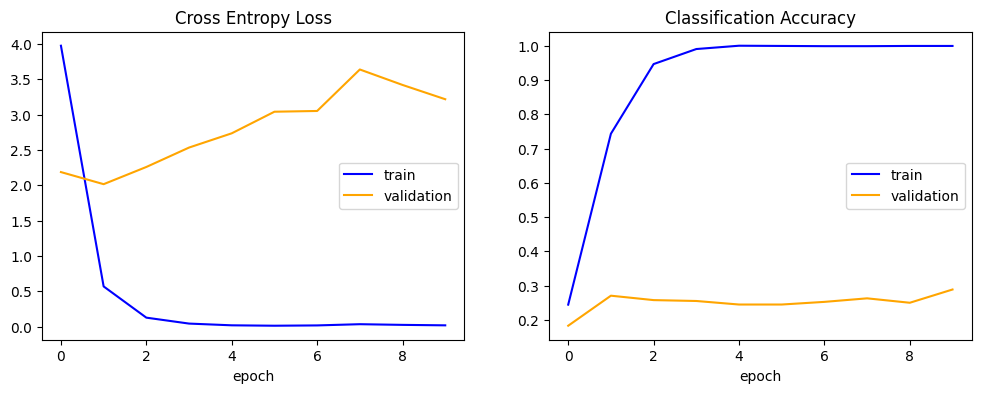

In [19]:
plt.figure(figsize=(12, 4))

# plot loss
plt.subplot(121)
plt.title('Cross Entropy Loss')
plt.plot(history_resnet.history['loss'], color='blue', label='train')
plt.plot(history_resnet.history['val_loss'], color='orange', label='validation')
plt.xlabel('epoch')

plt.legend()

# plot accuracy
plt.subplot(122)
plt.title('Classification Accuracy')
plt.plot(history_resnet.history['accuracy'], color='blue', label='train')
plt.plot(history_resnet.history['val_accuracy'], color='orange', label='validation')
plt.xlabel('epoch')

plt.legend()
plt.show()

Les courbes sont encore pires que précédemment.

#### 50 répétitions

In [20]:
def residual_module(input, channels):
  stride=1
  kernel_size=3
  x_shortcut = input
  x = BatchNormalization()(input)
  x = Activation('relu')(x)
  x = Conv1D(channels, (1))(x)

  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = Conv1D(channels, kernel_size, padding='same', strides=stride)(x)
  output = Add()([x, x_shortcut])
  return(output)

def construct_resnet():
    n_residual = 50
    print("Simple residual network with {} modules".format(n_residual))

    inputs = Input(shape=(400, 20))

    residual_i = inputs
    for _ in range(n_residual):
        residual_i = residual_module(residual_i, 20)

    gavg_1 = AveragePooling1D((2), strides=(1))(residual_i)

    flat_1 = Flatten()(gavg_1)

    output = Dense(10, activation="softmax")(flat_1)

    model = Model(inputs=inputs, outputs=output)

    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=['accuracy'], weighted_metrics=["accuracy"])

    return model

In [21]:
model_resnet = construct_resnet()
model_resnet.summary()

Simple residual network with 50 modules


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 400, 20)        │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_41    │ (None, 400, 20)        │             80 │ input_layer_2[0][0]    │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_41             │ (None, 400, 20)        │              0 │ batch_normalization_4… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_40 (Conv1D)        │ (None, 400, 20)        │            420 │ activation_41[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_42    │ (None, 400, 20)        │             80 │ conv1d_40[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_42             │ (None, 400, 20)        │              0 │ batch_normalization_4… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_41 (Conv1D)        │ (None, 400, 20)        │          1,220 │ activation_42[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_20 (Add)              │ (None, 400, 20)        │              0 │ conv1d_41[0][0],       │
│                           │                        │                │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_43    │ (None, 400, 20)        │             80 │ add_20[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_43             │ (None, 400, 20)        │              0 │ batch_normalization_4… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_42 (Conv1D)        │ (None, 400, 20)        │            420 │ activation_43[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_44    │ (None, 400, 20)        │             80 │ conv1d_42[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_44             │ (None, 400, 20)        │              0 │ batch_normalization_4… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_43 (Conv1D)        │ (None, 400, 20)        │          1,220 │ activation_44[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_21 (Add)         

 Total params: 169,810 (663.32 KB)

 Trainable params: 165,810 (647.70 KB)

 Non-trainable params: 4,000 (15.62 KB)

In [22]:
history_resnet = model_resnet.fit(X_train, y_train, validation_split=0.2, epochs=10, batch_size=50, class_weight=class_weights_dict)

Epoch 1/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 134s 2s/step - accuracy: 0.1266 - loss: 10.1907 - weighted_accuracy: 0.1316 - val_accuracy: 0.0387 - val_loss: 4.1496 - val_weighted_accuracy: 0.0387
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 45s 1s/step - accuracy: 0.5279 - loss: 1.7075 - weighted_accuracy: 0.6236 - val_accuracy: 0.1572 - val_loss: 2.7951 - val_weighted_accuracy: 0.1572
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 84s 2s/step - accuracy: 0.8159 - loss: 0.4077 - weighted_accuracy: 0.8656 - val_accuracy: 0.1598 - val_loss: 2.8621 - val_weighted_accuracy: 0.1598
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 63s 2s/step - accuracy: 0.9368 - loss: 0.1192 - weighted_accuracy: 0.9639 - val_accuracy: 0.2062 - val_loss: 2.7714 - val_weighted_accuracy: 0.2062
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 75s 2s/step - accuracy: 0.9885 - loss: 0.0404 - weighted_accuracy: 0.9941 - val_accuracy: 0.2139 - val_loss: 2.8807 - val_weighted_accuracy: 0.2139
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - accuracy: 0.9954

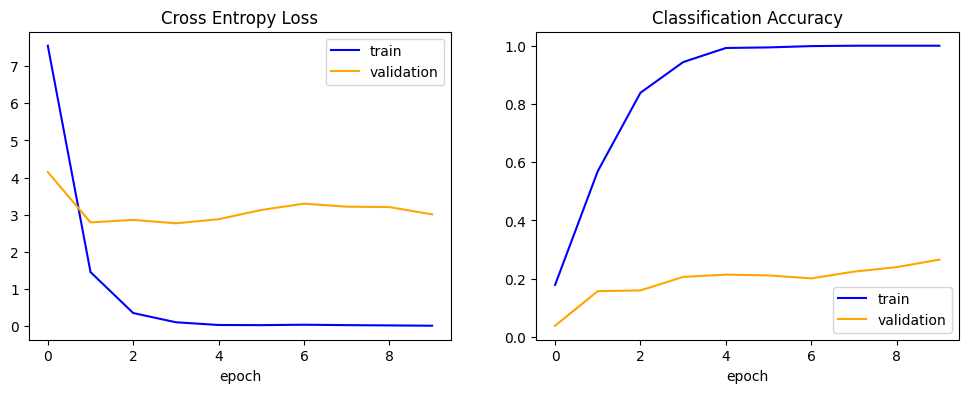

In [23]:
plt.figure(figsize=(12, 4))

# plot loss
plt.subplot(121)
plt.title('Cross Entropy Loss')
plt.plot(history_resnet.history['loss'], color='blue', label='train')
plt.plot(history_resnet.history['val_loss'], color='orange', label='validation')
plt.xlabel('epoch')

plt.legend()

# plot accuracy
plt.subplot(122)
plt.title('Classification Accuracy')
plt.plot(history_resnet.history['accuracy'], color='blue', label='train')
plt.plot(history_resnet.history['val_accuracy'], color='orange', label='validation')
plt.xlabel('epoch')

plt.legend()
plt.show()

Encore une fois, les courbes sont mauvaises.

Ce réseau ResNet est donc meilleur lorsqu'il contient moins de couches, ce qui n'est pas habituel.

## Comparaison des réseaux

On a construit deux réseaux de neurones pour classifier nos PSSM, un réseau de convolution et un ResNet dont les résultats principaux sont les suivants:

| Type        | Accuracy | Paramètres | Pire classe | Meilleure classe | Temps d'un batch (taille) |
|-------------|----------|------------|-------------|------------------|------------------------|
| Convolution       | 75,26%    | 261 610    | 0,5        | 1             | ~3s (16)                   |
| ResNet | 67,01%    | 81 610    | 0,33        | 1             | ~3s  (50)                 |

Les performances du réseau de convolution sont corrects. Il semblerai que l'accuracy stagne aux alentours de 0,7/0,8, peu importe les paramètres utilisés.

Le réseau ResNet n'a pas donné de resultats satisfaisants. Le modèle n'est pas robuste, et ne converge au mieux que vers une accuracy autour de 0,6.

Le réseau de convolution est donc le meilleur des deux. Ses performances peuvent peut-être être améliorées en testant d'autres architectures, le ResNet également. On peut néanmoins penser que ce problème d'apprentissage est en partie du aussi aux données, qui sont peu nombreuses et de qualité non satisfaisante, particulièrement sur la répartion des classes.